# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

9.5.0


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [3]:
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [4]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [33]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'test' or self.mode == 'val':
            transform = transforms.Compose([
                transforms.Resize(size=(224,224), antialias=True),
                transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            augs = transforms.RandomChoice([
                transforms.Compose([
                    transforms.Resize(size=300, max_size=301),
                    transforms.CenterCrop(size=300),
                    transforms.RandomCrop(250)
                ]),
                transforms.RandomRotation(degrees=(-25,25)),
                transforms.RandomHorizontalFlip(p=0.9),
                transforms.RandomVerticalFlip(p=0.9),
                transforms.Grayscale(num_output_channels=3),
                transforms.ColorJitter(saturation=0.9),
                transforms.ColorJitter(hue=0.45)
                
            ])
            transform = transforms.Compose([
                augs,
                transforms.Resize(size=(224,224), antialias=True),
                transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/simpsons-data/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/simpsons-data/testset/testset')

In [8]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [34]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [11]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

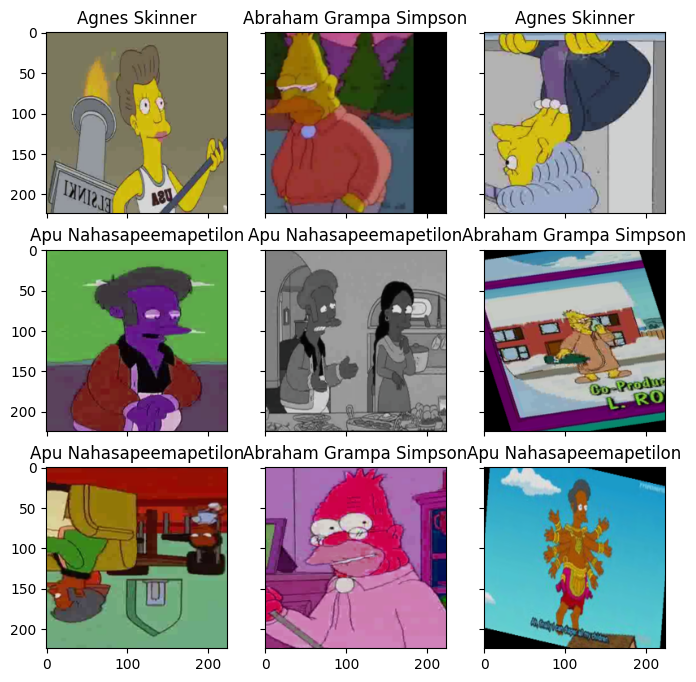

In [41]:
def plot_dataset(data):
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,1000))
        im_val, label = data[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        imshow(im_val.data.cpu(), \
              title=img_label,plt_ax=fig_x)
plot_dataset(train_dataset)

### Посмотрим на распределение классов

In [62]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [14]:
from collections import defaultdict

# Создайте словарь для подсчета количества изображений каждого класса
class_counts = defaultdict(int)

# Пройдите по всем изображениям в вашем обучающем наборе данных и подсчитайте количество для каждого класса
for image, label in train_dataset:
    class_counts[label] += 1

# Выведите количество изображений для каждого класса
for label, count in class_counts.items():
    print(f"Class {label}: {count} images")

Class 0: 685 images
Class 1: 32 images
Class 2: 467 images
Class 3: 80 images
Class 4: 1006 images
Class 5: 74 images
Class 6: 895 images
Class 7: 739 images
Class 8: 35 images
Class 9: 352 images
Class 10: 6 images
Class 11: 343 images
Class 12: 20 images
Class 13: 20 images
Class 14: 91 images
Class 15: 1684 images
Class 16: 373 images
Class 17: 904 images
Class 18: 233 images
Class 19: 2 images
Class 20: 1015 images
Class 21: 96 images
Class 22: 968 images
Class 23: 53 images
Class 24: 185 images
Class 25: 809 images
Class 26: 13 images
Class 27: 1089 images
Class 28: 1090 images
Class 29: 269 images
Class 30: 24 images
Class 31: 54 images
Class 32: 895 images
Class 33: 49 images
Class 34: 34 images
Class 35: 67 images
Class 36: 77 images
Class 37: 658 images
Class 38: 30 images
Class 39: 41 images
Class 40: 6 images
Class 41: 136 images


In [15]:
class_weights = [1/x for x in class_counts.values()]

In [16]:
class_weights

[0.00145985401459854,
 0.03125,
 0.0021413276231263384,
 0.0125,
 0.0009940357852882703,
 0.013513513513513514,
 0.0011173184357541898,
 0.0013531799729364006,
 0.02857142857142857,
 0.002840909090909091,
 0.16666666666666666,
 0.0029154518950437317,
 0.05,
 0.05,
 0.01098901098901099,
 0.0005938242280285036,
 0.002680965147453083,
 0.0011061946902654867,
 0.004291845493562232,
 0.5,
 0.0009852216748768472,
 0.010416666666666666,
 0.0010330578512396695,
 0.018867924528301886,
 0.005405405405405406,
 0.0012360939431396785,
 0.07692307692307693,
 0.0009182736455463728,
 0.0009174311926605505,
 0.0037174721189591076,
 0.041666666666666664,
 0.018518518518518517,
 0.0011173184357541898,
 0.02040816326530612,
 0.029411764705882353,
 0.014925373134328358,
 0.012987012987012988,
 0.001519756838905775,
 0.03333333333333333,
 0.024390243902439025,
 0.16666666666666666,
 0.007352941176470588]

In [17]:
weights = [class_weights[label] for _, label in train_dataset]

In [63]:
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_dataset), replacement=True) # получаем sampler

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [19]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.linear1 = nn.Sequential(
            nn.Linear(2400, 4096),
            nn.BatchNorm1d(4096), # добавим еще линейный слой с батч нормом и дропаутом
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096), # добавим еще линейный слой с батч нормом и дропаутом
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.out = nn.Linear(4096, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear2(x)
        logits = self.out(x)
        return logits

In [20]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [21]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [22]:
def train(train_dataset, val_dataset, model, epochs, batch_size, optimizer, sampler, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler = sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = {'Train_loss' : [],
              'Train_acc': [],
              'Val_loss' : [],
              'Val_acc' : []}
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        
            history['Train_loss'].append(train_loss)
            history['Train_acc'].append(train_acc)
            history['Val_loss'].append(val_loss)
            history['Val_acc'].append(val_acc)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [23]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [24]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

Запустим обучение сети.

In [45]:
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=0.005)#, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5) # добавим lr-reductor))

In [46]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64, optimizer=optimizer, sampler=sampler, scheduler=scheduler)

epoch:  20%|██        | 1/5 [02:50<11:20, 170.11s/it]


Epoch 001 train_loss: 2.1008     val_loss 2.2404 train_acc 0.4837 val_acc 0.4173


epoch:  40%|████      | 2/5 [05:41<08:32, 170.72s/it]


Epoch 002 train_loss: 1.4699     val_loss 2.2372 train_acc 0.6181 val_acc 0.4404


epoch:  60%|██████    | 3/5 [08:29<05:39, 169.73s/it]


Epoch 003 train_loss: 1.2700     val_loss 1.8529 train_acc 0.6684 val_acc 0.5224


epoch:  60%|██████    | 3/5 [10:35<07:03, 211.95s/it]


KeyboardInterrupt: 

Построим кривые обучения

In [27]:
history['Val_acc'] = [tensor_item.item() for tensor_item in history['Val_acc']]

In [28]:
def plot_training_history(histories, model_names):
    plt.figure(figsize=(12, 6), facecolor='grey')
    
    # График потерь на обучающем и тестовом наборах данных
    plt.subplot(1, 2, 1)
    colors = ['blue', 'red', 'green', 'orange']  # Список цветов для графиков
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['Train_loss']) + 1)
        plt.plot(epochs, history['Train_loss'], '--', color=color, label=f'Training loss - {name}')
        plt.plot(epochs, history['Val_loss'], color=color, label=f'Validation loss - {name}')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # График точности на обучающем и тестовом наборах данных
    plt.subplot(1, 2, 2)
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['Train_acc']) + 1)
        plt.plot(epochs, history['Train_acc'], '--', color=color, label=f'Training accuracy - {name}')
        plt.plot(epochs, history['Val_acc'], color=color, label=f'Validation accuracy - {name}')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.suptitle('Training History')
    plt.tight_layout()
    plt.show()

In [29]:
plot_training_history([history], ['BaselineCNN'])

NameError: name 'history' is not defined

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [30]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [31]:
from sklearn.metrics import f1_score
def f1_func(model):
    random_characters = int(np.random.uniform(0,1000))
    ex_img, true_label = val_dataset[random_characters]
    probs_im = predict_one_sample(model, ex_img.unsqueeze(0))
    idxs = list(map(int, np.random.uniform(0,1000, 20)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]
    
    f1 = f1_score(actual_labels, y_pred, average='micro')

    print("F1-оценка:", f1)


In [32]:
f1_func(simple_cnn)

F1-оценка: 0.6


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [79]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
def plot(model):
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,1000))
        im_val, label = val_dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



        imshow(im_val.data.cpu(), \
              title=img_label,plt_ax=fig_x)

        actual_text = "Actual : {}".format(img_label)

        fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("fantasy")
        prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred)*100
        y_pred = np.argmax(prob_pred)

        predicted_label = label_encoder.classes_[y_pred]
        predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
        predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

        fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=8, color='black',fontweight='bold')

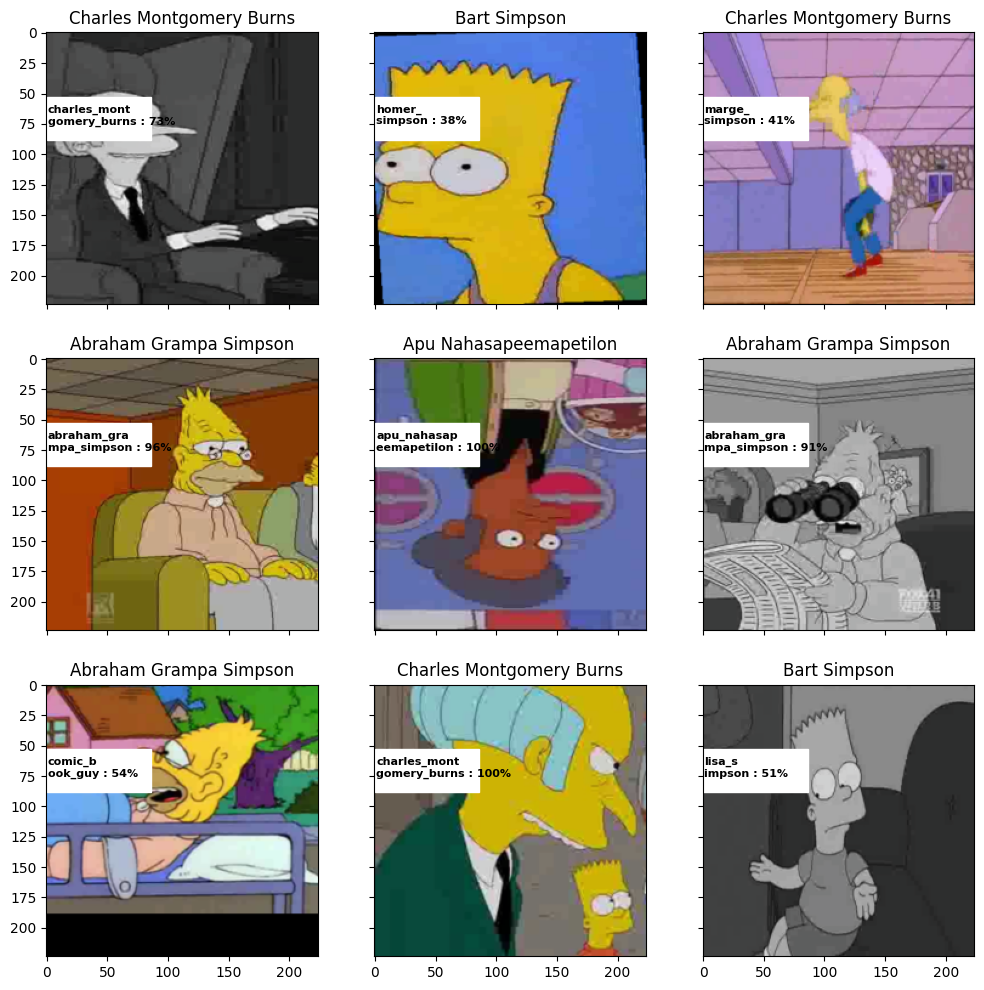

In [79]:
plot(simple_cnn)

# не вышло нормально обучить baseline model, будем resnet18 обучать

# Что же, нужен transfer learning! возьмем ResNet 18 и дообучим несколько слоев

In [47]:
import torchvision.models as models

In [69]:
resnet_model = models.resnet18(pretrained=True)

# замораживаем все слов

In [70]:
for param in resnet_model.parameters():
    param.requires_grad = False

In [71]:
for param in resnet_model.parameters():
    param.requires_grad = False
# Находим индекс последнего слоя второго блока "bottleneck"
bottleneck2_idx = 0  # Индекс слоя после второго блока "bottleneck"

# Размораживаем последние части слоев в layer4 после bottleneck2
for idx, (name, param) in enumerate(resnet_model.layer4.named_parameters()):
    if idx >= bottleneck2_idx:
        param.requires_grad = True

In [72]:
# делаем классификатор на 42 класса
num_features = resnet_model.fc.in_features

resnet_model.fc = nn.Linear(num_features, 42)

In [73]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [74]:
summary(resnet_model,
        input_size=(128, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [128, 3, 224, 224]   [128, 42]            --                   Partial
├─Conv2d (conv1)                         [128, 3, 224, 224]   [128, 64, 112, 112]  (9,408)              False
├─BatchNorm2d (bn1)                      [128, 64, 112, 112]  [128, 64, 112, 112]  (128)                False
├─ReLU (relu)                            [128, 64, 112, 112]  [128, 64, 112, 112]  --                   --
├─MaxPool2d (maxpool)                    [128, 64, 112, 112]  [128, 64, 56, 56]    --                   --
├─Sequential (layer1)                    [128, 64, 56, 56]    [128, 64, 56, 56]    --                   False
│    └─BasicBlock (0)                    [128, 64, 56, 56]    [128, 64, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [128, 64, 56, 56]    [128, 64, 56, 56]    (36,864)             False
│    │    

7,962,154 тренировочных параметров!

Запускаем:

In [75]:
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.0001)#, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5) # добавим lr-reductor))

In [76]:
history = train(train_dataset, val_dataset, model=resnet_model, epochs=15, batch_size=128, optimizer=optimizer, sampler = sampler, scheduler=scheduler)

epoch:   7%|▋         | 1/15 [02:49<39:29, 169.28s/it]


Epoch 001 train_loss: 2.0183     val_loss 1.0711 train_acc 0.6047 val_acc 0.8173


epoch:  13%|█▎        | 2/15 [05:40<36:58, 170.62s/it]


Epoch 002 train_loss: 0.5506     val_loss 0.5656 train_acc 0.8569 val_acc 0.8405


epoch:  20%|██        | 3/15 [08:28<33:50, 169.20s/it]


Epoch 003 train_loss: 0.3373     val_loss 0.4486 train_acc 0.9096 val_acc 0.8743


epoch:  27%|██▋       | 4/15 [11:15<30:50, 168.23s/it]


Epoch 004 train_loss: 0.2630     val_loss 0.3733 train_acc 0.9332 val_acc 0.8989


epoch:  33%|███▎      | 5/15 [14:01<27:56, 167.64s/it]


Epoch 005 train_loss: 0.2078     val_loss 0.3353 train_acc 0.9446 val_acc 0.9081


epoch:  40%|████      | 6/15 [16:49<25:10, 167.79s/it]


Epoch 006 train_loss: 0.1723     val_loss 0.2936 train_acc 0.9538 val_acc 0.9234


epoch:  47%|████▋     | 7/15 [19:41<22:31, 168.99s/it]


Epoch 007 train_loss: 0.1446     val_loss 0.2828 train_acc 0.9617 val_acc 0.9289


epoch:  53%|█████▎    | 8/15 [22:28<19:40, 168.58s/it]


Epoch 008 train_loss: 0.1384     val_loss 0.3083 train_acc 0.9624 val_acc 0.9163


epoch:  60%|██████    | 9/15 [25:18<16:53, 168.91s/it]


Epoch 009 train_loss: 0.1197     val_loss 0.2783 train_acc 0.9694 val_acc 0.9270


epoch:  67%|██████▋   | 10/15 [28:08<14:05, 169.17s/it]


Epoch 010 train_loss: 0.1146     val_loss 0.2719 train_acc 0.9675 val_acc 0.9284


epoch:  73%|███████▎  | 11/15 [30:55<11:14, 168.58s/it]


Epoch 011 train_loss: 0.0757     val_loss 0.2526 train_acc 0.9794 val_acc 0.9364


epoch:  80%|████████  | 12/15 [33:42<08:24, 168.18s/it]


Epoch 012 train_loss: 0.0667     val_loss 0.2624 train_acc 0.9822 val_acc 0.9327


epoch:  87%|████████▋ | 13/15 [36:29<05:35, 167.81s/it]


Epoch 013 train_loss: 0.0622     val_loss 0.2454 train_acc 0.9836 val_acc 0.9421


epoch:  93%|█████████▎| 14/15 [39:20<02:48, 168.69s/it]


Epoch 014 train_loss: 0.0618     val_loss 0.2421 train_acc 0.9829 val_acc 0.9385


epoch: 100%|██████████| 15/15 [42:08<00:00, 168.55s/it]


Epoch 015 train_loss: 0.0595     val_loss 0.2445 train_acc 0.9827 val_acc 0.9385


In [77]:
f1_func(resnet_model)

F1-оценка: 1.0


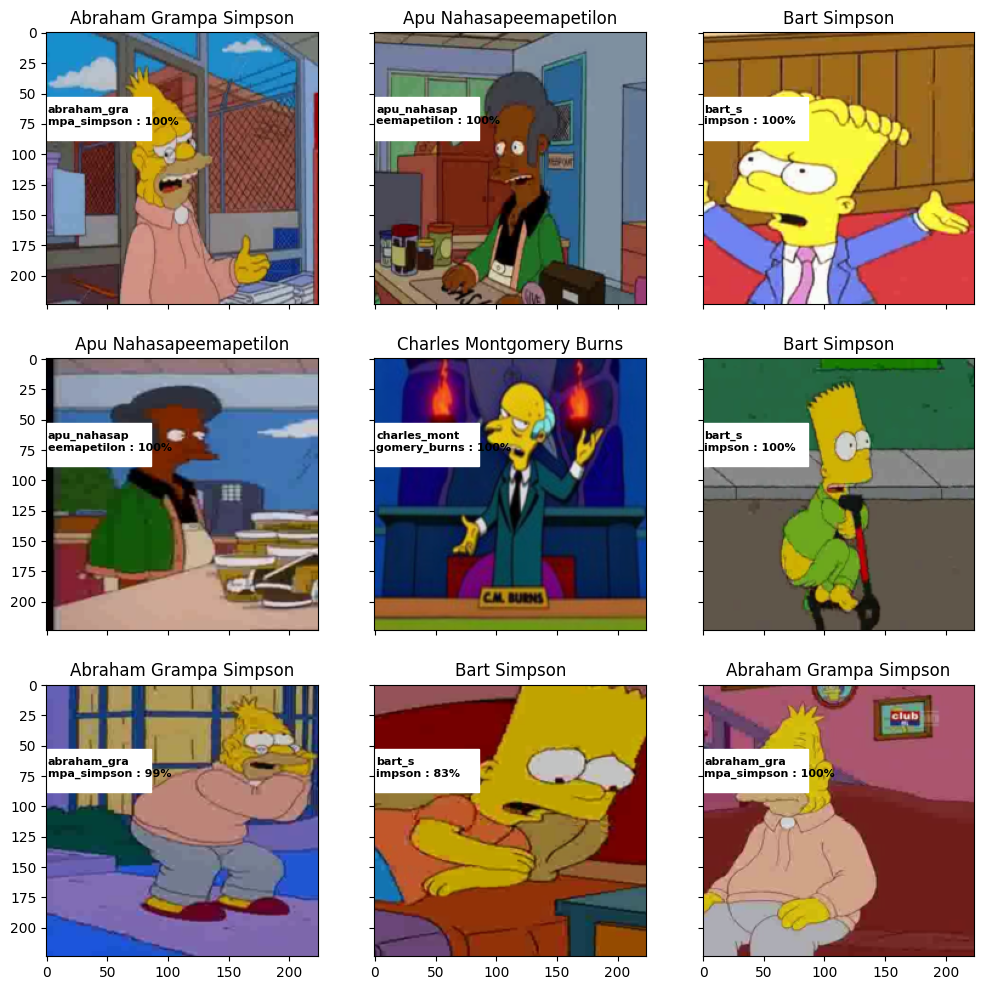

In [80]:
plot(resnet_model)

In [ ]:
history['Val_acc'] = [tensor_item.item() for tensor_item in history['Val_acc']]

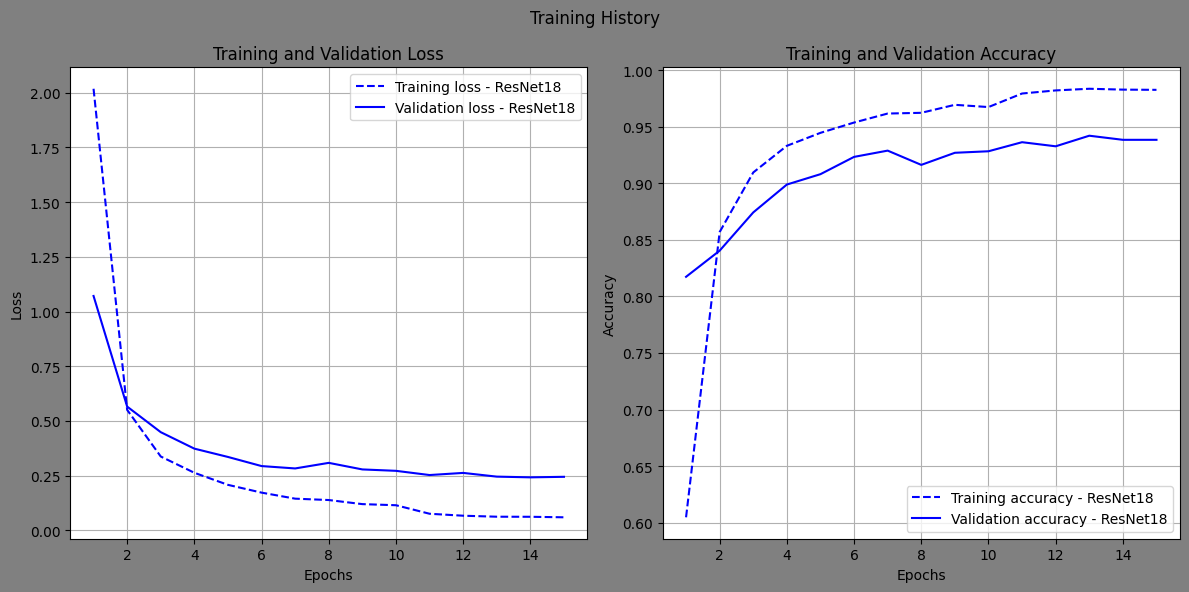

In [84]:
plot_training_history([history], ['ResNet18'])

In [85]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [89]:
!ls /kaggle/input/simpsons-data/

characters_illustration.png  sample_submission.csv  testset  train


In [90]:
import pandas as pd
my_submit = pd.read_csv("/kaggle/input/simpsons-data/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [104]:
for index, row in my_submit.iterrows():
    # Обновляем значение первой колонки
    my_submit.at[index, 'Id'] = test_filenames[index]  # Пример обновления значения

    # Обновляем значение второй колонки
    my_submit.at[index, 'Expected'] = preds[index]

In [105]:
my_submit

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [106]:
my_submit.to_csv('resnet_18.csv', index=False)

In [107]:
!ls

label_encoder.pkl  resnet_18.csv  simple_cnn_baseline.csv
